In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone --recursive https://github.com/OlegJakushkin/SRDRM
%cd SRDRM


fatal: destination path 'SRDRM' already exists and is not an empty directory.
/content/SRDRM


In [ ]:
!pip uninstall -yq tf-nightly-gpu  tensorflow keras tensorflow-gpu keras-preprocessing keras-applications  scipy
!pip install tensorflow-gpu==1.13.1
!pip install numpy keras==2.3 keras-applications==1.0.6 keras-preprocessing==1.0.5 blend_modes youtube_dl pafy natsort  fvcore scipy==1.1.0 deprecated  numpy   blend_modes

  Using cached https://files.pythonhosted.org/packages/7b/b1/0ad4ae02e17ddd62109cd54c291e311c4b5fd09b4d0678d3d6ce4159b0f0/tensorflow_gpu-1.13.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/79/4c/7c3275a01e12ef9368a892926ab932b33bb13d55794881e3573482b378a7/Keras_Preprocessing-1.1.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/71/e3/19762fdfc62877ae9102edf6342d71b28fbfd9dea3d2f96a882ce099b03f/Keras_Applications-1.0.8-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/1b/18/2e1ef121e5560ac24c7ac9e363aa5fa7006c40563c989e7211aba95b793a/Keras-2.3.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/3f/c4/2ff40221029f7098d58f8d7fb99b97e8100f3293f9856f0fb5834bef100b/Keras_Applications-1.0.6-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/fc/94/74e0fa783d3fc07e41715973435dd051ca89c550881b3454233c39c73e69/Keras_Preprocessing-1.0.5-py2.py3-none-any.wh

350
--- 107.73764705657959 seconds ---


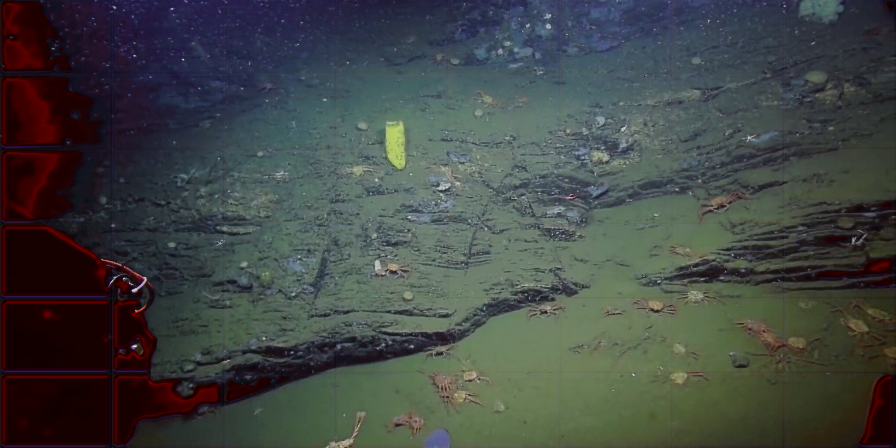

364
378
392
406
420
434
448
462
476
490
504
518
532
546
560
574
588
602
616
630
644
658
672
686
700


KeyboardInterrupt: ignored

In [ ]:
"""
# > Script for evaluating 4x SISR models 
#    - Paper: https://arxiv.org/pdf/1909.09437.pdf
#
# Maintainer: Jahid (email: islam034@umn.edu)
# Interactive Robotics and Vision Lab (http://irvlab.cs.umn.edu/)
# Any part of this repo can be used for academic and educational purposes only
"""
import os
import time
import ntpath
import numpy as np
from scipy import misc
from keras.models import model_from_json
## local libs
from utils.data_utils import getPaths, preprocess, deprocess
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import numpy
import pafy
from google.colab.patches import cv2_imshow
from google.colab import output
from PIL import Image
import shutil

video_url = 'https://www.youtube.com/watch?v=Mq8LFUyvBrM'
base_path = '/content/drive/MyDrive/SRDRM/'
target_out_mask_path_base = "/content/drive/MyDrive/fss/w5s1-as_w1s5/query/" + "sr"
model_name = "srdrm-gan"
ckpt_name =  "model_68_"
checkpoint_dir  = os.path.join("/content/drive/MyDrive/SRDRM/checkpoints/USR_4x/", model_name) 
model_h5 = os.path.join(checkpoint_dir, ckpt_name+".h5")  
model_json = os.path.join(checkpoint_dir, ckpt_name + ".json")

assert (os.path.exists(model_h5) and os.path.exists(model_json))
# load json and create model
with open(model_json, "r") as json_file:
    loaded_model_json = json_file.read()
generator = model_from_json(loaded_model_json)
# load weights into new model
generator.load_weights(model_h5)
print("\nLoaded data and model")

 # testing loop
times = []; s = time.time()
def video():
    fidx =0
    while os.path.isfile(target_out_mask_path_base + str(fidx)+ ".avi"):
      fidx = fidx + 1
    out_name  = target_out_mask_path_base + str(fidx) + ".avi"
    out_name_tmp  = '/content/' + str(fidx) + ".avi"
    colorwriter = cv2.VideoWriter(out_name_tmp, cv2.VideoWriter_fourcc(*'XVID'), 2, (224*4, 224*2), 1)
    urlPafy  = pafy.new(video_url)
    videoplay   = urlPafy.getbest()
    # open url with opencv
    cap = cv2.VideoCapture(videoplay.url)
    if not cap.isOpened():
        print('video not opened')
        exit(-1)

    frid = 0
    print("Started reading video file")
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    start_time = time.time()
    fps = cap.get(cv2.CAP_PROP_FPS)
    skeep_frames = int(fps/2)
    print(skeep_frames)
    while True:
        # read frame
        ret, frame = cap.read()

        if not ret:
            break
        frid = frid + 1
        if frid % skeep_frames != 0:
          continue
        print(frid)
        imgheight=frame.shape[0]
        imgwidth=frame.shape[1]
        #if imgwidth > 1000:
        #  frame = cv2.resize(frame,( int(imgwidth/2), int(imgheight/2)))
        #lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)

        #lab_planes = cv2.split(lab)

        #clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8,8))

        #lab_planes[0] = clahe.apply(lab_planes[0])

        #lab = cv2.merge(lab_planes)

        #frame = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

        y1 = 0
        imgheight=frame.shape[0]
        imgwidth=frame.shape[1]
        K=int(imgheight / 120)
        L=int(imgwidth / 160)
        M = imgheight//K
        N = imgwidth//L
        blocks=[]
        for y in range(0,imgheight,M):
            for x in range(0, imgwidth, N):
                y1 = y + M
                x1 = x + N
                tiles = frame[y:y+M,x:x+N]
                im = preprocess(tiles)
                im = np.expand_dims(im, axis=0)
                gen = generator.predict(im)
                gen = deprocess(gen) * 255 # Rescale to 0-1
                blocks.append(gen)

        imgheight *=4   
        imgwidth *=4   
        frame = cv2.resize(frame,(imgwidth, imgheight))    
        imgheight=frame.shape[0]
        imgwidth=frame.shape[1]

        M1 = (imgheight//K)
        N1 = (imgwidth//L)
        I = 0
        for y in range(0,imgheight,M1):
            for x in range(0, imgwidth, N1):
                frame[y:y+M1,x:x+N1] = blocks[I]
                I = I+1

        frame = cv2.resize(frame,(224*4, 224*2))
        colorwriter.write(frame)

        if frid % 50 == 0: 
          output.clear()
          print(frid)
          print("--- %s seconds ---" % (time.time() - start_time))
          cv2_imshow(frame)
          start_time = time.time()

    print("saving results")
    colorwriter.release()
    shutil.copy(out_name_tmp, out_name)
    print("done")

video()

4050
--- 54.354779958724976 seconds ---


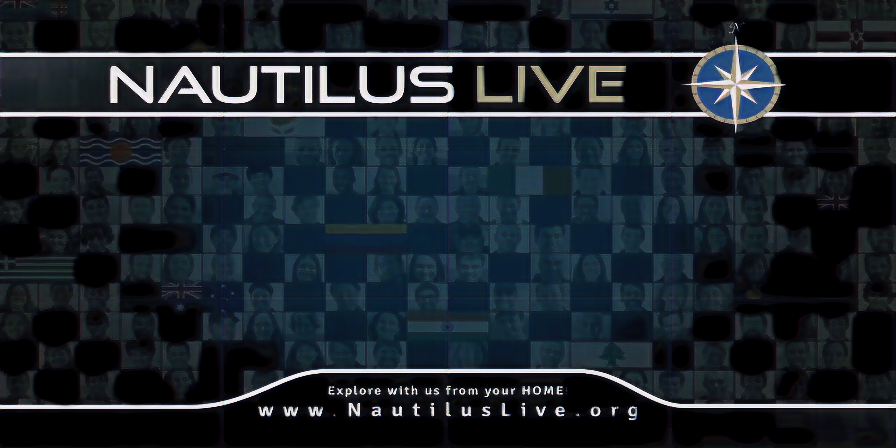

saving results
done
